In [1]:
# numpy and pandas for data manipulation
import pandas as pd 
pd.options.mode.chained_assignment = None # no warnings
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud


# import tensorflow, , keras
import sys
sys.path.append('./')
from text_processing import text_processing
from classifiers import batch_classify
#from train import train
import tensorflow_hub as hub

Load Data
Load data using read_csv()

In [2]:
# reading in the CSV files using the pandas read_csv function. we have also dropped the id column from the train set as we won’t need this for training the model.
train = pd.read_csv('./Data/train.csv').drop('id', axis=1)
test = pd.read_csv('./Data/test.csv')
ID = test['id']
test = test.drop('id', axis=1)
test['target']=''


Data Preprocessing
Using the following text preprocessing methods:
[1] Format text: correct spelling, remove emojis, and remove stop_words
[2] Format keyword: fill missing keywords for certain tweets following specific scenarios
[3] Format location: fill missing locations for certain tweets following specific scenarios

** For deatils per each scenario, please follow the text_processing documentation

Scikit-pipeline
Next, we will create a scikit-pipeline with following methods:
[1] CountVectorizer() - split data into tokens, or individual words, count the frequency in which each word appears in the text, and then represent theses counts as a sparse matrix
[2] TfidfTransformer() - apply a weightning to the word counts produced by CountVectorizer(), this weightning is to scale down impact of very frequently occuring words in the text
[3] SGDClassifier() - generally regarded as one of the best text classification algorithms

In [3]:
train_clean = text_processing(train)
test_clean = text_processing(test)
train_clean.to_csv('./Data/train_clean.csv', index=False)
test_clean.to_csv('./Data/test_clean.csv', index=False)


C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(latitude, longitude, altitude)
C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(latitude, longitude, altitude)
C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibi

In [3]:
train_clean = pd.read_csv('./Data/train_clean.csv')
test_clean = pd.read_csv('./Data/test_clean.csv')

In [4]:
# searching for duplicated tweets with different target and removing them
df_mislabeled = train_clean.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
train_clean = train_clean[~train_clean['text'].isin(df_mislabeled.index.tolist())]

In [5]:
y = train_clean['target']
X = train_clean.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [11]:

# split the train data into a training and test set
#train_clean['keyword'] = train_clean['keyword']+' ' + train_clean['location'] + ' ' + train_clean['text']

X_train, X_test, y_train, y_test = train_test_split(train_clean['text'], train_clean['target'], test_size=0.2, random_state=0)

Try Different Classifiers

In [17]:
train_clean = train_clean.fillna("neutral")
train_clean['full text'] = train_clean['text'] + ' ' +train_clean['keyword'] + ' ' +train_clean['location'] 
X_train, X_test, y_train, y_test = train_test_split(train_clean['full text'], train_clean['target'], test_size=0.1, random_state=0)

In [6]:
skf = StratifiedKFold(n_splits=2, random_state=20, shuffle=True)

for fold, (trn_idx, test_idx) in enumerate(skf.split(train_clean['text'], train_clean['keyword'])): 
    X_train = train_clean.loc[trn_idx, 'text']
    X_test = train_clean.loc[test_idx, 'text']
    y_train = train_clean.loc[trn_idx, 'target']
    y_test = train_clean.loc[test_idx, 'target']


ValueError: Input contains NaN

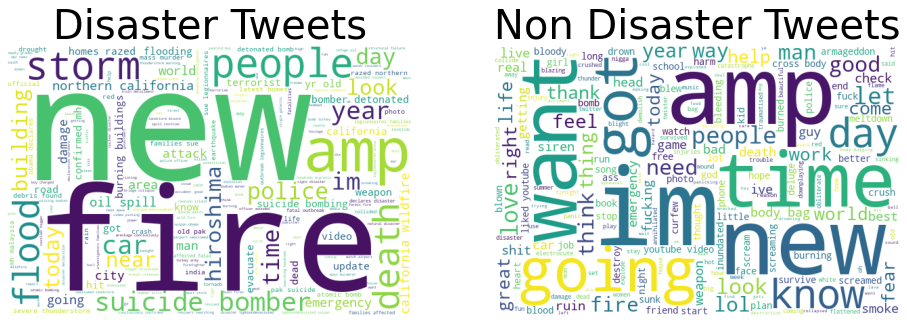

In [6]:
disaster_tweets = train_clean[train_clean['target']==1]['text']
non_disaster_tweets = train_clean[train_clean['target']==0]['text']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);


In [12]:
tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = tweets_pipeline.fit_transform(X_train)
X_test_tranformed = tweets_pipeline.transform(X_test)

In [13]:

df_results = batch_classify(X_train_tranformed, y_train,X_test_tranformed, y_test)
print(df_results.sort_values(by='F1_score', ascending=False))

trained Logistic Regression in 0.00 s
trained Decision Tree in 0.66 s
trained k-Nearest Neighbors in 0.02 s
trained Linear SVM in 2.14 s
trained Gradient Boosting Classifier in 0.75 s
trained Random Forest in 2.12 s
trained RidgeClassifier in 0.02 s
trained AdaBoost in 0.44 s
trained MNB in 0.00 s
trained Perceptron in 0.00 s
[19:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


trained xgboost in 29.77 s
trained catboost in 169.62 s
                      Classifier  Area Under Curve  Accuracy  Precision  \
0            Logistic Regression          0.801457  0.808874   0.803723   
8                            MNB          0.802978  0.816382   0.854406   
3                     Linear SVM          0.797353  0.810239   0.841210   
6                RidgeClassifier          0.784241  0.785666   0.745098   
5                  Random Forest          0.778957  0.792491   0.819048   
10                       xgboost          0.771915  0.786348   0.815891   
2            k-Nearest Neighbors          0.763544  0.776109   0.788497   
9                     Perceptron          0.748867  0.750171   0.703428   
11                      catboost          0.766984  0.784983   0.840336   
7                       AdaBoost          0.757461  0.770648   0.784240   
1                  Decision Tree          0.743434  0.747440   0.709828   
4   Gradient Boosting Classifier          0.

In [ ]:
# ML pipeline
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', SGDClassifier())
])

model = pipeline_sgd.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))


Submission

In [12]:
submission_test_clean = test_clean.copy()
submission_test_clean = submission_test_clean['text']


0                             happened terrible car crash
1             heard earthquake different cities stay safe
2         forest fire spot pond geese fleeing street save
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258       earthquake safety los angeles safety fasteners
3259    storm ri worse hurricane cityampothers hardest...
3260                        green line derailment chicago
3261                 meg issues hazardous weather outlook
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [13]:

submission_test_clean = test_clean.copy()
submission_test_clean = submission_test_clean['text']
submission_test_pred = model.predict(submission_test_clean)

In [ ]:
test.insert(loc=0, column='id', value=ID)
id_col = test['id']
submission_df_1 = pd.DataFrame({"id": id_col,
                               "target": submission_test_pred})
submission_df_1.head()

In [15]:
submission_df_1.to_csv('submission_1.csv', index=False)

In [16]:
train.to_csv('./Data/after_preprocessing.csv', index=False)